## 业务背景
比赛要求参赛者解决一个二分类问题, 即预测用户在点击移动端关于一些App的广告后是否会下载该App; 这也是很多互联网公司所关注的"转化率"预估问题. 从另一个角度看, 在广告商投放广告之后, 广告平台方可以通过刷流量的方式来增加点击量, 但却不下载App. 因此虽然流量很高, 但都是虚假流量, 转化率很低, 并不能为广告商增加实际收益. 因此这次比赛也可以理解为防止刷流量搞欺诈

## 数据字段
TalkingData提供了样本量近1.9亿的训练数据, 包括了2017.11.06至2017.11.09之间的数据, 每条数据记录为一次广告点击, 包括以下字段:  
ip: 点击的ip地址;  
app: 广告商提供的app id;  
device: 用户的移动设备id, 如iphone 6, iphone 7;  
os: 用户移动设备的操作系统版本id;  
channel: 广告投放渠道id;  
click_time: 点击时间(UTC时间), 格式为yyyy-mm-dd hh:mm:ss;  
attributed_time: 若用户下载了app, 这就是下载时间;  
is_attributed: 是否下载了app, 这是目标变量;  
这里ip, app, device, os, channel都是分类变量且经过编码处理  

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)})
plt.figure(figsize=(12,5))
plt.show()

In [3]:
"""
训练集太大，只读取前10000000行来分析
"""
#import first 10,000,000 rows of train and all test data
train = pd.read_csv('../data/train.csv', nrows=10000000)
test = pd.read_csv('../data/test.csv')

In [4]:
train.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0


In [5]:
test.head(10)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00
5,5,110769,18,1,13,107,2017-11-10 04:00:00
6,6,12540,3,1,1,137,2017-11-10 04:00:00
7,7,88637,27,1,19,153,2017-11-10 04:00:00
8,9,14932,18,1,10,107,2017-11-10 04:00:00
9,8,123701,12,1,53,424,2017-11-10 04:00:00


In [6]:
"""
ip, app, device, os and channel 是类别变量，但是是整数，所以要处理

"""
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

In [7]:
"""
把时间变量转化为时间类型
"""
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

In [8]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000,18717,10000000.0
unique,68740.0,332.0,940.0,292.0,170.0,29943,15698,2.0
top,73516.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 23:36:23,0.0
freq,51711.0,1291185.0,9381146.0,2410148.0,793105.0,1261,6,9981283.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-07 00:12:03,2017-11-07 15:59:53,NaN


/data/home/linliming/anaconda3/envs/tf/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


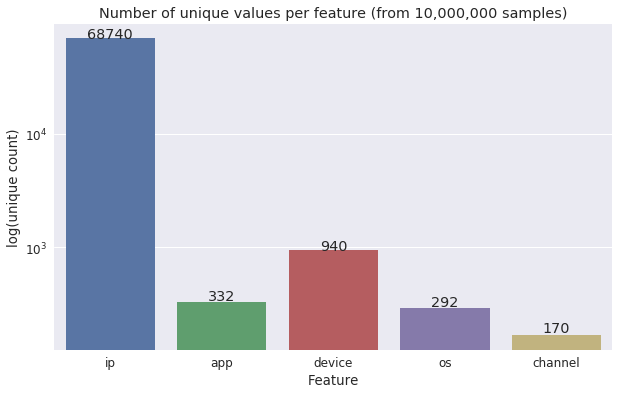

In [9]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
####增加如下代码
cols = pd.Series(cols).unique()
uniques = pd.Series(uniques).unique()
#########
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
plt.show()

In [10]:
"""
确认下载时间是否会有缺失
"""
#double check that 'attributed_time' is not Null for all values that resulted in download (i.e. is_attributed == 1)
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,18717,18717.0
unique,15698,1.0
top,2017-11-06 23:36:23,1.0
freq,6,18717.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:59:53,NaN


In [11]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


**分析** :
- 点击后下载的比例太少
- 有些ip出现超过5000次，可能不是设备的ip而是网络
- 训练集是2017-11-6号开始，测试集是2017-11-10号开始

/data/home/linliming/anaconda3/envs/tf/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


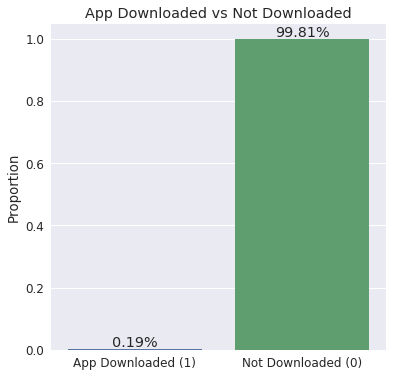

In [12]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], pd.Series([mean, 1-mean]).unique())
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")
plt.show()

In [13]:
### 看ip的频率
temp = train['ip'].value_counts().reset_index(name = 'counts')
temp.columns = ['ip','counts']
temp[:10]

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


In [14]:
train = train.merge(temp,on ='ip',how='left')
train.head

<bound method NDFrame.head of              ip app device  os channel          click_time attributed_time  \
0         83230   3      1  13     379 2017-11-06 14:32:21             NaT   
1         17357   3      1  19     379 2017-11-06 14:33:34             NaT   
2         35810   3      1  13     379 2017-11-06 14:34:12             NaT   
3         45745  14      1  13     478 2017-11-06 14:34:52             NaT   
4        161007   3      1  13     379 2017-11-06 14:35:08             NaT   
5         18787   3      1  16     379 2017-11-06 14:36:26             NaT   
6        103022   3      1  23     379 2017-11-06 14:37:44             NaT   
7        114221   3      1  19     379 2017-11-06 14:37:59             NaT   
8        165970   3      1  13     379 2017-11-06 14:38:10             NaT   
9         74544  64      1  22     459 2017-11-06 14:38:23             NaT   
10       172522   3      1  25     379 2017-11-06 14:38:27             NaT   
11       105861   3      1  13    

In [15]:
train[train['is_attributed'] == 1].sort_values('counts',ascending = False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7912764,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,51711
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,51711
3350587,73516,72,1,18,101,2017-11-06 17:46:37,2017-11-07 09:46:44,1,51711
3416495,73516,10,1,25,377,2017-11-06 17:50:33,2017-11-06 18:50:59,1,51711
6331848,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,51711
7543731,73516,155,1,19,213,2017-11-06 23:18:10,2017-11-07 15:07:40,1,51711
5144374,73516,9,1,37,234,2017-11-06 20:49:25,2017-11-06 20:53:19,1,51711
3651360,73516,107,1,19,171,2017-11-06 18:05:12,2017-11-06 23:44:44,1,51711
6368416,73516,10,1,13,377,2017-11-06 22:38:04,2017-11-06 22:52:43,1,51711
2073360,73516,9,1,13,134,2017-11-06 16:52:12,2017-11-06 16:52:20,1,51711


In [16]:
train[train['is_attributed']==1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

In [17]:
#convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

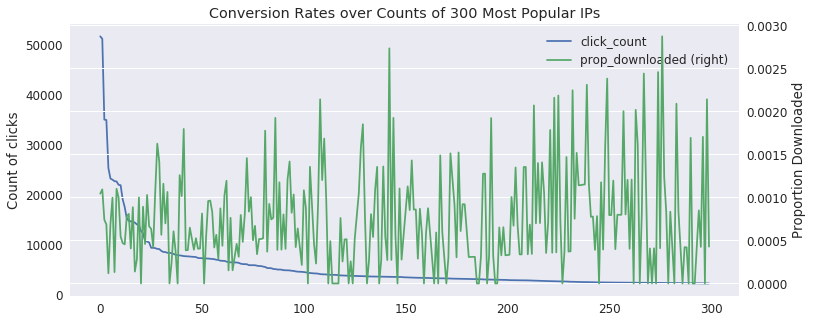

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73516        51711         0.001044
1    73487        51215         0.001093
2     5314        35073         0.000741
3     5348        35004         0.000686
4    53454        25381         0.000118
5   105560        23289         0.000687
6   100275        23070         0.000997
7   114276        22774         0.000132
8   201182        22719         0.001100
9   105475        22047         0.000998
10   95766        21966         0.000546
11   26995        19166         0.000470
12  209663        17605         0.000454
13   43793        15398         0.000779
14  137052        14840         0.000809
15   86767        14742         0.000407
16   17149        14673         0.000886
17  111025        14493         0.000138
18  138561        14119         0.000283
19  147957        14012         0.000999


In [18]:
"""
Conversion rates over Counts of 300 most popular IPs
Conversions are noisy and do not appear to correlate with how popular an IP is.
"""
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

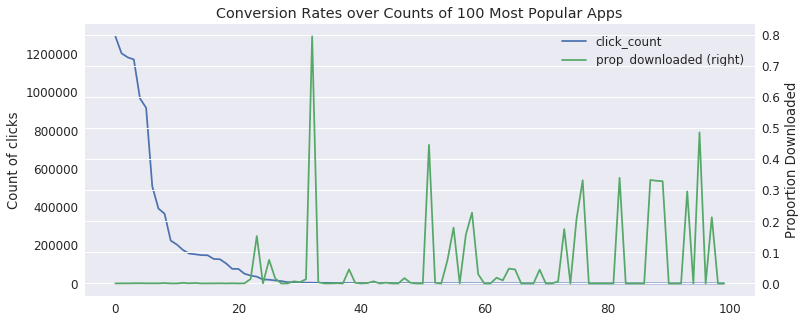

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12      1291185         0.000140
1    2      1202534         0.000388
2   15      1181585         0.000277
3    3      1170412         0.000630
4    9       966839         0.000869
5   18       917820         0.000397
6   14       507491         0.000483
7    1       391508         0.000350
8    8       364361         0.001441
9   21       223823         0.000089
10  13       203332         0.000103
11  20       174792         0.001962
12  24       156247         0.000550
13  11       152367         0.001503
14  23       148119         0.000027
15   6       147356         0.000176
16  64       127923         0.000258
17  26       126630         0.000537
18  25       104855         0.000095
19  27        76417         0.000523


In [19]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

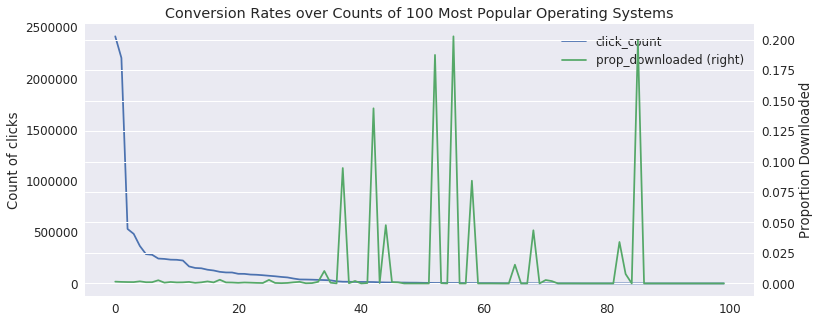

Counversion Rates over Counts of Most Popular Operating Systems
     os  click_count  prop_downloaded
0    19      2410148         0.001489
1    13      2199778         0.001271
2    17       531695         0.001155
3    18       483602         0.001115
4    22       365576         0.001729
5    10       285907         0.001011
6     8       279549         0.001037
7     6       242799         0.002619
8     9       239377         0.000656
9    25       232143         0.001206
10   15       230832         0.000853
11   20       223820         0.000920
12   16       166165         0.001258
13   37       151274         0.000509
14    3       147970         0.000919
15   14       134127         0.001663
16   41       126565         0.000877
17    1       113395         0.003042
18  607       107442         0.000856
19   12       107005         0.000757


In [20]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

In [21]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

Count of clicks and proportion of downloads by device:
    device  click_count  prop_downloaded
0        1      9381146         0.001326
1        2       456617         0.000208
2     3032       104393         0.000000
3        0        46476         0.091961
4       59         1618         0.001236
5       40          462         0.246753
6        6          458         0.222707
7       16          334         0.242515
8       18          247         0.226721
9       33          204         0.196078
10      21          190         0.242105
11    3033          151         0.178808
12     154          151         0.178808
13      37          145         0.193103
14      30          126         0.301587
15      46          123         0.211382
16     114          122         0.172131
17       7          121         0.231405
18      88          117         0.324786
19     109          113         0.300885
20      67          111         0.297297
21     748          103         0.000000
22

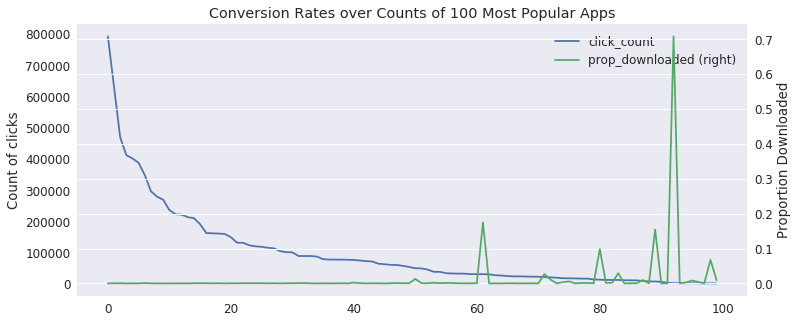

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      245       793105         0.000105
1      134       630888         0.000558
2      259       469845         0.000653
3      477       412559         0.000073
4      121       402226         0.000323
5      107       388035         0.000379
6      145       348862         0.001155
7      153       296832         0.000182
8      205       279720         0.000232
9      178       269720         0.000119
10     265       236949         0.000236
11     128       223205         0.000130
12     140       222096         0.000347
13     459       214060         0.000187
14     442       210687         0.000646
15     215       191618         0.000778
16     122       163312         0.000582
17     280       162425         0.000345
18     379       161608         0.000811
19     135       160215         0.000200


In [22]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

In [23]:
train_smp = pd.read_csv('../data/train_sample.csv')
train_smp.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0


In [24]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

In [25]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  
train_smp

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00
5,93663,3,1,17,115,2017-11-09 01:22:13,NaT,0,2017-11-09 01:00:00
6,17059,1,1,17,135,2017-11-09 01:17:58,NaT,0,2017-11-09 01:00:00
7,121505,9,1,25,442,2017-11-07 10:01:53,NaT,0,2017-11-07 10:00:00
8,192967,2,2,22,364,2017-11-08 09:35:17,NaT,0,2017-11-08 10:00:00
9,143636,3,1,19,135,2017-11-08 12:35:26,NaT,0,2017-11-08 13:00:00


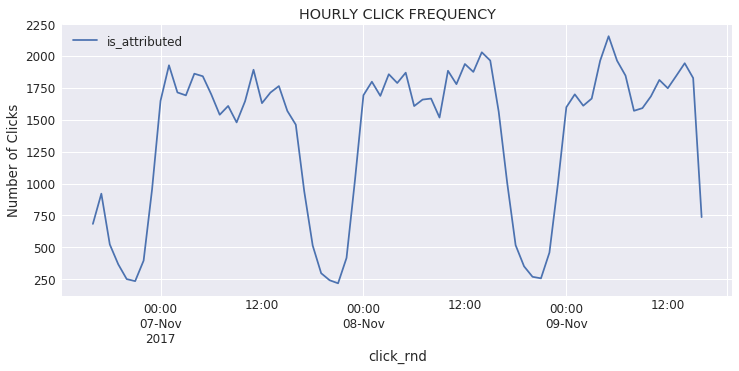

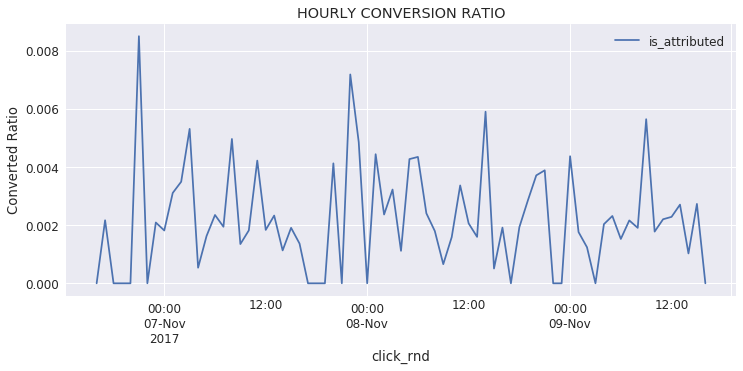

In [26]:
#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

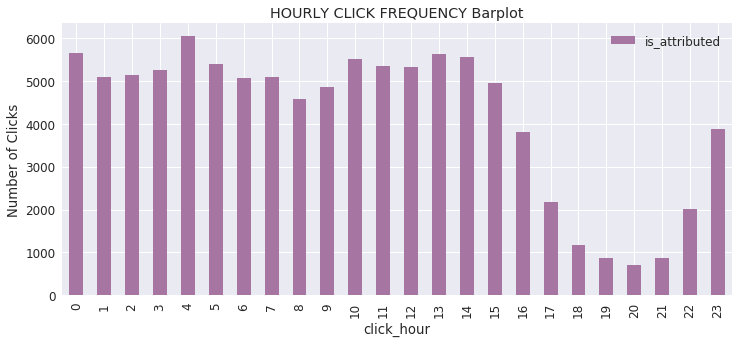

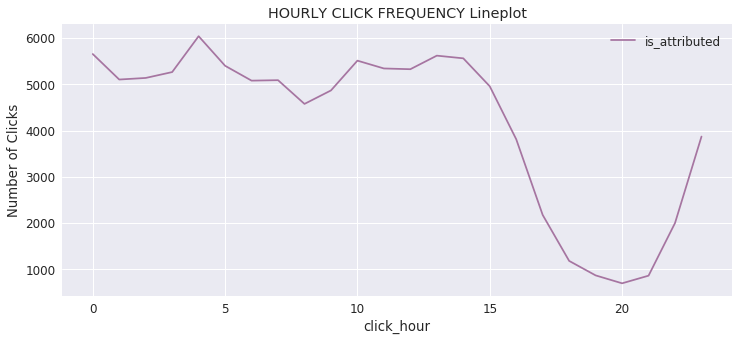

In [27]:
#extract hour as a feature
train_smp['click_hour']=train_smp['click_time'].dt.hour

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

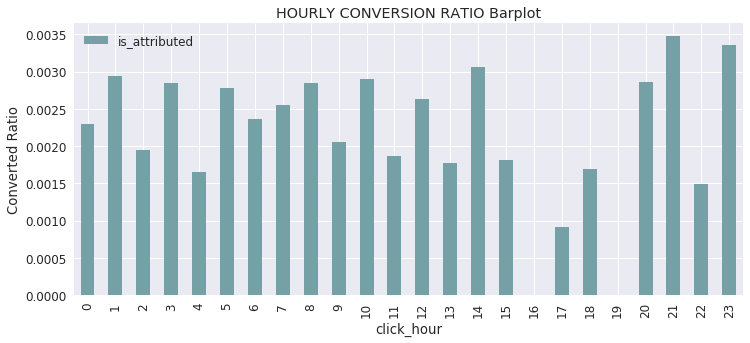

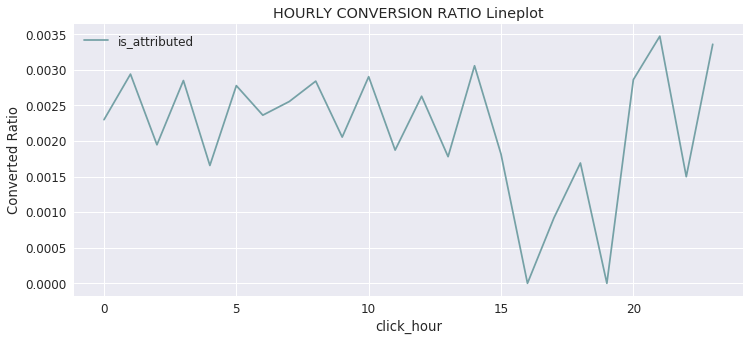

In [28]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

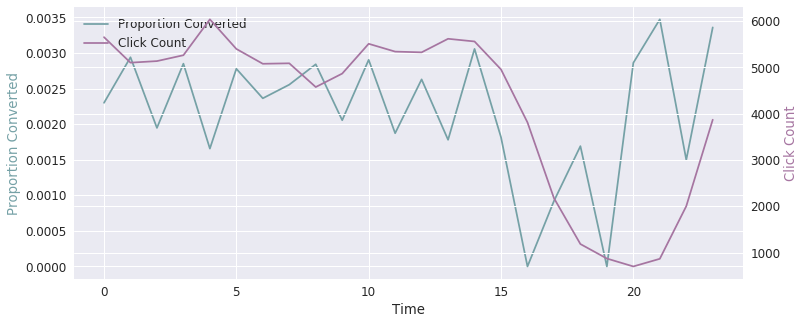

In [29]:
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


/data/home/linliming/anaconda3/envs/tf/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


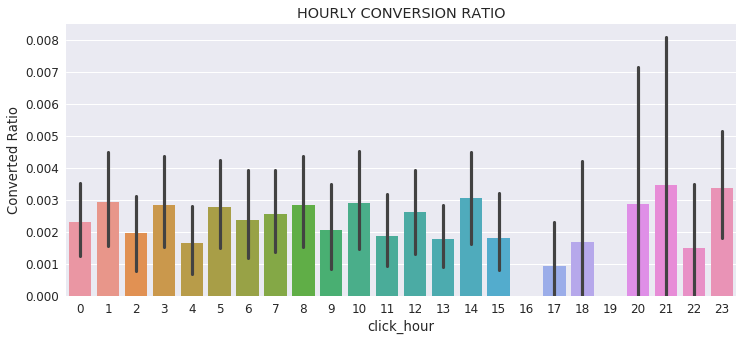

In [30]:
sns.barplot('click_hour', 'is_attributed', data=train_smp)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [31]:
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']
#check:
train_smp[train_smp['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,timePass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,01:39:29


In [32]:
train_smp['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

In [33]:
#check first 10,000,000 of actual train data
train['timePass']= train['attributed_time']-train['click_time']
train['timePass'].describe()

count                     18717
mean     0 days 03:48:02.893732
std      0 days 05:29:41.396810
min             0 days 00:00:00
25%             0 days 00:01:26
50%             0 days 00:25:03
75%             0 days 06:34:14
max             0 days 23:52:38
Name: timePass, dtype: object